In [41]:
import scipy.integrate
import numpy as np
import matplotlib.patches as mpatch
from matplotlib.transforms import Bbox
from matplotlib.patches import FancyBboxPatch
from scipy.signal import find_peaks
from tqdm import tqdm
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [55]:
peak1 = np.load("peak1.npy")
peak2 = np.load("peak2.npy")
full1 = np.load("full1.npy")
full2 = np.load("full2.npy")

In [59]:
xs = []
ys = []
for i in range(20):
    for j in range(2,20):
        if peak1[i,j] == 2.:
            xs.append(i)
            ys.append(j)

In [60]:
np.save("a0s", xs)
np.save("bxs", ys)

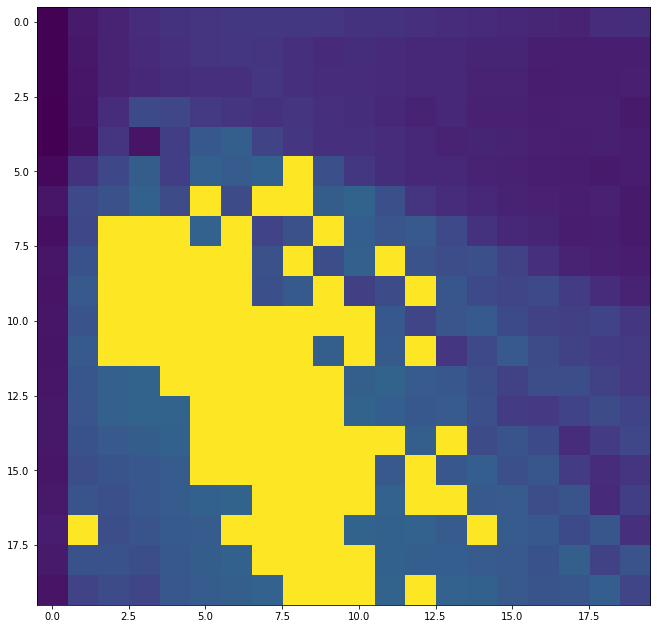

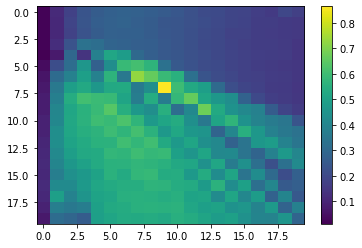

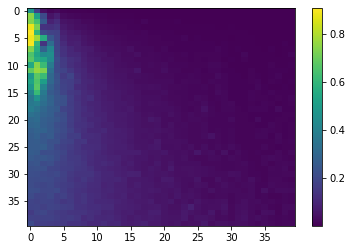

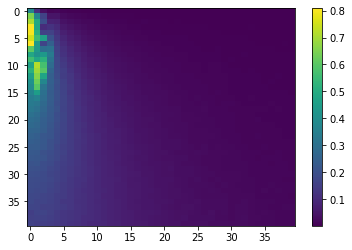

In [56]:
plt.figure(figsize=(11,11))
peak1 = np.load("peak1.npy")
#peak1[abs(peak1-0.6)<0.05] = 2.
peak1[(peak1>0.65)] = 2.
plt.imshow(peak1, aspect='auto')

plt.figure()
plt.imshow(full1, aspect='auto')
plt.colorbar()

plt.figure()
plt.imshow(peak2, aspect='auto')
plt.colorbar()
plt.figure()
plt.imshow(full2, aspect='auto')
plt.colorbar()

In [33]:
def wrapper(a0, bx, density):
    shift = np.pi
    phase_y=0.0
    phase_z=phase_y+shift
    duration=4.0*2*np.pi
    thickness=0.01*2*np.pi
    alpha=density*thickness
    epsilon=alpha*0.5

    def pulse_y(xi):
        if((xi)>=0) and ((xi)<duration):
            toret = a0*np.sin(np.pi*(xi)/duration)**2*np.sin(xi-duration/2+phase_y)
        else:
            toret = 0.0
        return toret

    def pulse_z(xi):
        if((xi)>=0) and ((xi)<duration):
            toret = a0*np.sin(np.pi*(xi)/duration)**2*np.sin(xi-duration/2+phase_z)
        else:
            toret = 0.0
        return toret

    x=np.linspace(0,20*2*np.pi, 1000)
    pulsey=np.zeros(len(x))
    pulsez=np.zeros(len(x))

    for n,xx in enumerate(x):
        #print(n,xx)
        pulsey[n]=pulse_y(xx)
        pulsez[n]=pulse_z(xx)

    #plt.figure()
    #plt.plot(pulsey)
    #plt.plot(pulsez)
    # for RK4 we assume:
    # xi = t-x
    # y0 -> h(xi)
    # y1 -> x(xi)
    # y2 -> y(xi)
    # y3 -> z(xi)

    def f(y,xi):
        ay = pulse_y(xi)
        az = pulse_z(xi)
        u_perp_sqr = (ay-epsilon*y[2] - bx*y[3])**2+(az-epsilon*y[3] + bx*y[2])**2
        #restoring_field=sign(y[1])
        #restoring_field=density*y[1]
        restoring_field=np.tanh(y[1]/(thickness/4))

        f0 = epsilon*(restoring_field-u_perp_sqr/(1+u_perp_sqr))
        f1 = 0.5/y[0]**2*(1-y[0]**2+u_perp_sqr)
        f2 = 1./y[0]*(ay-epsilon*y[2] - bx*y[3])
        f3 = 1./y[0]*(az-epsilon*y[3] + bx*y[2])
        return [f0,f1,f2,f3]

    Time=25
    Npercycle=100000
    NofTS=Time*Npercycle
    xi_end=Time*2*np.pi

    xi = np.linspace(0, xi_end, NofTS)
    dxi=xi[1]-xi[0]

    y0=[1.0,0.0,0.,0.]

    sol = odeint(f, y0, xi)

    h=sol[:,0]
    x=sol[:,1]
    y=sol[:,2]
    z=sol[:,3]

    t=xi+x

    tdetector = t+x

    ux=np.gradient(x,xi)*h
    uy=np.gradient(y,xi)*h
    uz=np.gradient(z,xi)*h

    gamma=np.sqrt(1+ux**2+uy**2+uz**2)
    vx = ux/gamma
    gamma_x=1./np.sqrt(1-vx**2)

    Eydetector = epsilon*uy/gamma/(1+vx)
    Ezdetector = epsilon*uz/gamma/(1+vx)

    Ey_interp=np.interp(t, tdetector, Eydetector)
    Ez_interp=np.interp(t, tdetector, Ezdetector)

    sp_y=np.fft.fft(Ey_interp)
    sp_z=np.fft.fft(Ez_interp)
    w=np.fft.fftfreq(len(Ey_interp), d=t[1]-t[0])

    filter_center=15.0
    filter_width=5.
    bandgap_filter_minus=np.exp(-(w*2*np.pi-filter_center)**16/filter_width**16)
    bandgap_filter_plus=np.exp(-(w*2*np.pi+filter_center)**16/filter_width**16)
    bandgap_filter=bandgap_filter_minus+bandgap_filter_plus


    sp_y_filt = bandgap_filter*sp_y
    sp_z_filt = bandgap_filter*sp_z

    filtered_y=np.fft.ifft(sp_y_filt)
    filtered_z=np.fft.ifft(sp_z_filt)

    ### Stokes parameters and ellipticity
    spy=sp_y_filt
    spz=sp_z_filt

    S0=spy*np.conjugate(spy)+spz*np.conjugate(spz)
    S1=spy*np.conjugate(spy)-spz*np.conjugate(spz)
    S2=2*np.real(spy*np.conjugate(spz))
    S3=2*np.imag(spy*np.conjugate(spz))

    #V=sqrt(S1**2+S2**2+S3**2)/S0
    ind1 = np.where((w*2*np.pi)>10)[0][0]
    ind2 = np.where((w*2*np.pi)>=20)[0][0]
    #print(ind1, ind2)

    chi=0.5*np.arctan((S3+1e-200)/(np.sqrt(S1**2+S2**2)+1e-200))
    ellips = abs(np.tan(chi))[ind1:ind2]
    #figure(figsize=(12,5))
    #plot(w*2*pi, abs(tan(chi)))
    peaks = find_peaks(ellips)
    #plt.plot(w[ind1:ind2][peaks[0]]*2*pi, ellips[peaks[0]], 'x')
    #xlim(0,30)

    #print("peak ellipticity")
    #print(mean(ellips[peaks[0]]))
    #print("all ellipticity")
    #print(mean(abs(tan(chi))[ind1:ind2]))
    return [np.mean(ellips[peaks[0]]), np.mean(ellips)]

[  1.           3.53846154   6.07692308   8.61538462  11.15384615
  13.69230769  16.23076923  18.76923077  21.30769231  23.84615385
  26.38461538  28.92307692  31.46153846  34.          36.53846154
  39.07692308  41.61538462  44.15384615  46.69230769  49.23076923
  51.76923077  54.30769231  56.84615385  59.38461538  61.92307692
  64.46153846  67.          69.53846154  72.07692308  74.61538462
  77.15384615  79.69230769  82.23076923  84.76923077  87.30769231
  89.84615385  92.38461538  94.92307692  97.46153846 100.        ]
[  200.           451.28205128   702.56410256   953.84615385
  1205.12820513  1456.41025641  1707.69230769  1958.97435897
  2210.25641026  2461.53846154  2712.82051282  2964.1025641
  3215.38461538  3466.66666667  3717.94871795  3969.23076923
  4220.51282051  4471.79487179  4723.07692308  4974.35897436
  5225.64102564  5476.92307692  5728.20512821  5979.48717949
  6230.76923077  6482.05128205  6733.33333333  6984.61538462
  7235.8974359   7487.17948718  7738.46153846

2it [00:04,  2.07s/it]


KeyboardInterrupt: 

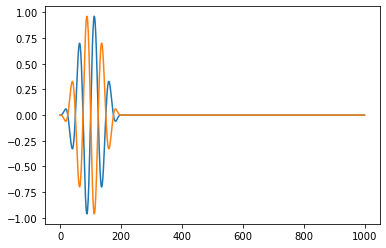

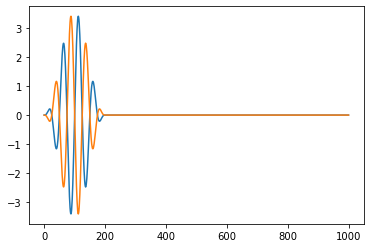

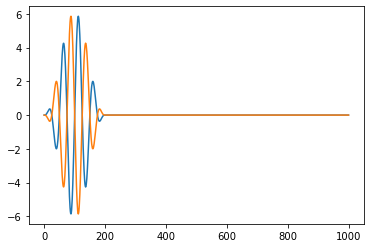

In [34]:
a0s = np.linspace(1, 100, 40)
bxs = np.linspace(1, 100, 40)
eps = np.linspace(200, 10000, 40)
print(a0s)
print(eps)
peak1 = np.zeros((40,40))
full1 = np.zeros((40,40))

peak2 = np.zeros((40,40))
full2 = np.zeros((40,40))

for i, a0 in tqdm(enumerate(a0s)):
    for j, bx in enumerate(bxs):
        peak1[i,j], full1[i,j] = wrapper(a0, bx, 800)
        break

#for j, bx in tqdm(enumerate(bxs)):
#    for k, density in enumerate(eps):
#        peak2[j,k], full2[j,k] = wrapper(20, bx, density)

In [ ]:
plt.plot(x_picwig, picwig, label='picwig')
plt.plot(Ys, full, label='model', lw=4)
plt.ylabel("ellipticity", fontsize=15)
plt.xlabel("$a0_y$", fontsize=15)
plt.xticks(fontsize=15)
plt.legend(fontsize=15)
plt.yticks(fontsize=15);

In [ ]:
plt.plot(Ys, full)
plt.ylabel("ellipticity", fontsize=15)
plt.xlabel("$a0_y$", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

In [ ]:
picwig = np.load("output_1p_4500_elip.npy")
x_picwig = np.linspace(1, 30, 4500)

In [ ]:
picwig.shape